In [1]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import GridWorld_env
from replay_buffer import ReplayBuffer, PrioritizedReplayBuffer
import gymnasium as gym
import random
import math
from itertools import count

device = "cuda" if torch.cuda.is_available() else "cpu"
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

In [2]:
class Vanilla_DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(Vanilla_DQN, self).__init__()
               
        self.conv1 = nn.Conv3d(3, 29, 3, 1, 1)
        
        self.conv2 = nn.Conv3d(32, 67, 3, 1, 1)
        
        self.fc1 = nn.Linear((64 + 3*2)*input_dim * input_dim * input_dim, 1024)
        
        self.actions = nn.Linear(1024, action_dim)
        self.advantage = nn.Linear(1024, 1)
    def forward(self, x):
        original_state = x
               
        x = self.conv1(x)
        
        x = torch.cat([x, original_state], dim=1)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = torch.cat([x, original_state], dim=1)
        
        x = F.relu(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu(x)
        actions = self.actions(x)
        
        x = self.advantage(x) + (actions - actions.mean(dim=1, keepdim=True))
        return x


In [3]:
BATCH_SIZE = 32
GAMMA = 0.9
EPS_START = 0.99
EPS_END = 0.01
EPS_DECAY = 150000
TAU = 0.0003
STEPSIZE = 0.0000625
BETA_START = 0.4
BETA_END = 1
BETA_LINEAR_CAP = 850 * 850
N_STEP = 1

n_actions = 8
env = gym.make("GridWorld_env/GridWorld", dimension_size=4, path="targets")
env.reset()

policy_net = Vanilla_DQN(4, 8)
target_net = Vanilla_DQN(4, 8)


policy_net.cuda()
target_net.cuda()
target_net.load_state_dict(policy_net.state_dict())

optimiser = optim.Adam(policy_net.parameters(), lr=STEPSIZE, eps=1.5e-4)
memory = PrioritizedReplayBuffer(obs_dim=(3,4,4,4), size=8192, n_step=N_STEP, gamma = GAMMA)

steps_done = 0

c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [4]:
def select_action(state, greedy = False):
    global steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if greedy:
        return policy_net(state).max(1).indices.view(1,1)
        
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    

In [5]:
episode_durations = []

def plot_durations(show_result = False):
    plt.figure(1)
    
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
        plt.pause(0.001)
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())
                

In [6]:
def optimise_model(beta):
    if len(memory) < BATCH_SIZE * 64:
        return 0, 0
    transitions = memory.sample_batch() 
    batch = Transition(
        torch.tensor(transitions["obs"], device=device),
        torch.tensor(transitions["acts"], device=device, dtype=torch.int64),
        torch.tensor(transitions["next_obs"], device=device),
        torch.tensor(transitions["rews"], device=device)
    )
    
    indices = transitions["indices"]
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s.unsqueeze(0) for s in batch.next_state if s is not None])
    
    state_batch = batch.state
    action_batch = batch.action
    reward_batch = batch.reward
    
    tmp = policy_net(state_batch)
    state_action_values = tmp.gather(1, action_batch.unsqueeze(1))
    next_state_values = torch.zeros(BATCH_SIZE, device = device)
    
    
    max_a = policy_net(non_final_next_states).detach().max(1).indices
    next_state_values[non_final_mask] = target_net(non_final_next_states).detach().gather(1, max_a.unsqueeze(1)).squeeze(1)
    with torch.no_grad():
        expected_state_action_values = (GAMMA ** N_STEP) * next_state_values + reward_batch
    criterion = nn.MSELoss()
    
    
    loss = criterion(state_action_values , expected_state_action_values.unsqueeze(1))
    
    optimiser.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimiser.step()
    
    new_priorities = torch.abs(state_action_values - expected_state_action_values.unsqueeze(1)).detach().cpu().numpy() + 1e-7 #loss.detach().cpu().numpy() + 1e-6
    return loss.item(), reward_batch.float()
        

In [7]:
reward_plot = []


c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


KeyboardInterrupt: 

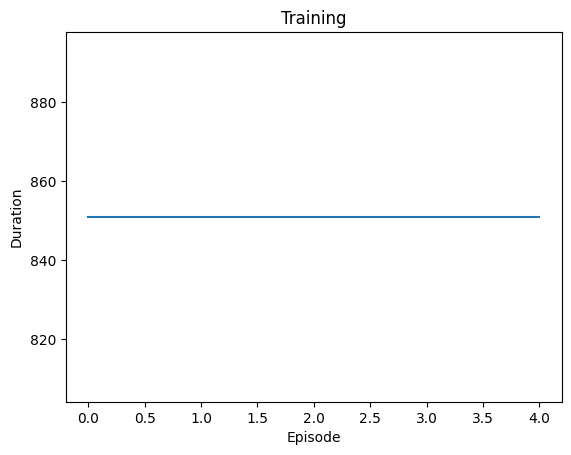

In [8]:
if torch.cuda.is_available():
    num_episodes = 1000
else:
    num_episodes = 1



for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cummulative_reward = 0
    for t in count():
        action = select_action(state)


        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        cummulative_reward += reward
        reward = torch.tensor([reward], device=device)
        
        done = terminated or truncated
        if terminated:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.store(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done)
        state = next_state

        beta = BETA_START + (BETA_END - BETA_START) * (steps_done) / BETA_LINEAR_CAP if steps_done < BETA_LINEAR_CAP else BETA_END
        l, r = optimise_model(beta)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
        
    if i_episode % 10 == 0 and i_episode > 1:
        print("Episode: {0} Loss {1} Mean Sample Reward {2}:" .format(i_episode, l, r.mean().item()))
        #print(env.unwrapped.get_seqsuence())
        env.unwrapped.render()
    
    reward_plot.append(cummulative_reward)

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


In [ ]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
for t in range(50):
    action = select_action(state, greedy = True)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the transition in memory
    #memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    if terminated or truncated:
        break
    env.unwrapped.render()
    display.clear_output(wait=True)

    


In [ ]:
torch.save(policy_net, "vanilla_dqn_policy.pt")
torch.save(target_net, "vanilla_dqn_target.pt")

np.save("duration_plot.npy", np.array(episode_durations))
np.save("reward_plot.npy", np.array(reward_plot))